<a href="https://colab.research.google.com/github/ricardoinaciopt/seminars3b/blob/main/S3b_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
!rm -rf TIVlib
!git clone https://github.com/aframires/TIVlib.git
%cd TIVlib
!pip install soundfile

The following commented code is only necessary if you want to extract the features from the musc dataset again. If not, they are already extracted, and available in the repository, under `musical_features.csv`

In [ ]:
# import os
# from google.colab import drive
# import warnings
# warnings.filterwarnings('ignore')
# drive.mount('/content/drive/')
# %cd /content/drive/My Drive/Colab Notebooks/ # use this if you want to extract features from the folder with songs

In [ ]:
# if not os.path.exists("music_folder"):
#   print("Music data not found, extracting...")
#   !unzip archive.zip -d music_folder
# else:
#   print("Music data already extracted.")
# music_folder = '/content/drive/My Drive/Colab Notebooks/music_folder'
# music_folder

In [ ]:
# import random
# from IPython.display import Audio

# def select_random_file_from_subfolder(directory_path):
#     subfolders = [os.path.join(directory_path, d) for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
#     if not subfolders:
#         return None
#     random_subfolder = random.choice(subfolders)
#     print(f"Selected subfolder: {random_subfolder}")
#     files = [f for f in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, f))]
#     print(f"Files in selected subfolder: {files}")
#     return os.path.join(random_subfolder, random.choice(files))

# random_file = select_random_file_from_subfolder("music_folder/Data/genres_original/")
# print(random_file)
# Audio(random_file)

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from TIVlib import TIV as tiv

def load_and_clip_audio(file_path, clip_duration=30):
    try:
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        if duration > clip_duration:
            y = y[:clip_duration * sr]
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def extract_features(y, sr):
    try:
        # beat + tempo
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)

        # rhythm
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        beat_intervals = np.diff(beat_times) if len(beat_times) > 1 else [0]
        mean_beat_interval = np.mean(beat_intervals) if len(beat_intervals) > 0 else 0

        # harmonic + percussive
        harmonic, percussive = librosa.effects.hpss(y)

        # chroma / TIV
        chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        beat_chroma = librosa.util.sync(chroma_cqt, beat_frames, aggregate=np.mean)
        tiv_features = {"Chromaticity": [], "Diatonicity": [], "Dissonance": [], "Magnitude": []}
        for beat_index in range(beat_chroma.shape[1]):
            pcp_vector = beat_chroma[:, beat_index]
            tiv_profile = tiv.from_pcp(pcp_vector, data_type='audio')
            tiv_features["Chromaticity"].append(tiv.chromaticity(tiv_profile))
            tiv_features["Diatonicity"].append(tiv.diatonicity(tiv_profile))
            tiv_features["Dissonance"].append(tiv.dissonance(tiv_profile))
            tiv_features["Magnitude"].append(tiv.mags(tiv_profile))
        tiv_aggregated = {k: np.mean(v) for k, v in tiv_features.items()}

        # librosa
        librosa_features = {
            "Spectral Centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            "Spectral Bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            "Spectral Rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            "RMS Energy": np.mean(librosa.feature.rms(y=y)),
            "Zero Crossing Rate": np.mean(librosa.feature.zero_crossing_rate(y)),
            "MFCC Mean": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)),
            "MFCC Variance": np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)),
            "Spectral Contrast": np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
            "Harmony Mean": np.mean(harmonic),
            "Harmony Variance": np.var(harmonic),
            "Percussive Mean": np.mean(percussive),
            "Percussive Variance": np.var(percussive),
            "Tempo": tempo,
            "Onset Strength Mean": np.mean(onset_env),
            "Onset Strength Variance": np.var(onset_env),
            "Mean Beat Interval": mean_beat_interval
        }

        return {**librosa_features, **tiv_aggregated}
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

In [ ]:
# def process_dataset(dataset_path, clip_duration=30, max_files=None):
#     data = []
#     file_count = 0

#     for folder, _, files in os.walk(dataset_path):
#         genre = os.path.basename(folder)
#         for file in files:
#             if file.endswith(('.wav', '.mp3')):
#                 file_path = os.path.join(folder, file)
#                 relative_path = os.path.relpath(file_path, dataset_path)
#                 print(f"Processing {relative_path}...")

#                 y, sr = load_and_clip_audio(file_path, clip_duration)
#                 if y is None or sr is None:
#                     continue

#                 features = extract_features(y, sr)
#                 if features is None:
#                     continue

#                 features.update({
#                     "File Name": relative_path,
#                     "Target": genre
#                 })
#                 data.append(features)
#                 file_count += 1

#                 if max_files is not None and file_count >= max_files:
#                     print(f"Reached maximum file limit: {max_files}")
#                     return pd.DataFrame(data)

#     return pd.DataFrame(data)

# final_df = process_dataset(music_folder)
# final_df.set_index('File Name', inplace=True)
# final_df.fillna(0, inplace=True)
# final_df.to_csv('musical_features.csv')

In [2]:
import os
import pandas as pd
if os.getcwd() == "/content/TIVlib":
  os.chdir("/content/")
if os.path.exists("musical_features.csv"):
  final_df = pd.read_csv('musical_features.csv')
  final_df.set_index('File Name', inplace=True)
  final_df.fillna(0, inplace=True)
  final_df["Tempo"] = final_df["Tempo"].apply(lambda x: float(x.strip('[]')))
final_df

,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,RMS Energy,Zero Crossing Rate,MFCC Mean,MFCC Variance,Spectral Contrast,Harmony Mean,Harmony Variance,...,Percussive Variance,Tempo,Onset Strength Mean,Onset Strength Variance,Mean Beat Interval,Chromaticity,Diatonicity,Dissonance,Magnitude,Target
File Name,,,,,,,,,,,,,,,,,,,,,
Data/genres_original/blues/blues.00015.wav,1420.411479,1730.917102,2930.240615,0.080639,0.063718,-4.253306,6240.9680,21.364321,-1.398105e-05,0.004730,...,0.002336,103.359375,1.460053,1.988041,0.604686,0.157652,0.061687,0.918362,0.766360,blues
Data/genres_original/blues/blues.00014.wav,1172.276301,1705.858377,2345.777482,0.066936,0.045046,-5.842912,9272.8510,21.617302,-1.175124e-04,0.004717,...,0.001200,151.999081,1.387912,2.054584,0.381615,0.191156,0.077172,0.893918,0.999138,blues
Data/genres_original/blues/blues.00016.wav,1455.042471,1825.909025,3009.965132,0.081419,0.061351,-3.659566,6137.8228,21.057216,-2.477557e-05,0.004509,...,0.002416,198.768029,1.406042,1.771489,0.301376,0.109594,0.070701,0.913721,0.802472,blues
Data/genres_original/blues/blues.00017.wav,1088.778116,1410.835953,2134.753758,0.093259,0.048324,-1.510453,7137.2295,21.719440,-1.125272e-05,0.006768,...,0.001524,172.265625,1.587924,3.025460,0.355014,0.128485,0.093376,0.890263,0.998963,blues
Data/genres_original/blues/blues.00013.wav,1324.331754,1827.384464,2710.366944,0.113189,0.051417,-1.767808,5141.6553,21.416027,-1.289524e-05,0.012688,...,0.001604,107.666016,1.376919,2.038245,0.560851,0.157062,0.079569,0.895618,1.000221,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Data/genres_original/rock/rock.00096.wav,2006.009248,2068.224879,4147.166589,0.076425,0.097659,-1.511460,3393.6875,22.669137,7.467836e-07,0.003983,...,0.000818,117.453835,1.085211,0.857461,0.512261,0.118948,0.232386,0.807903,1.766494,rock
Data/genres_original/rock/rock.00097.wav,2077.166788,1926.895810,4030.750627,0.081583,0.121824,-1.601387,3030.4124,22.317139,-9.287926e-08,0.003827,...,0.001124,129.199219,1.058164,0.715323,0.468893,0.091103,0.154549,0.878217,1.086236,rock
Data/genres_original/rock/rock.00095.wav,2008.537046,2106.349206,4254.124276,0.079441,0.089267,-1.013770,3521.4834,22.980343,2.329412e-06,0.004596,...,0.000681,103.359375,1.174831,1.467421,0.579551,0.124972,0.263404,0.793682,1.856938,rock


___
## Feature Analysis

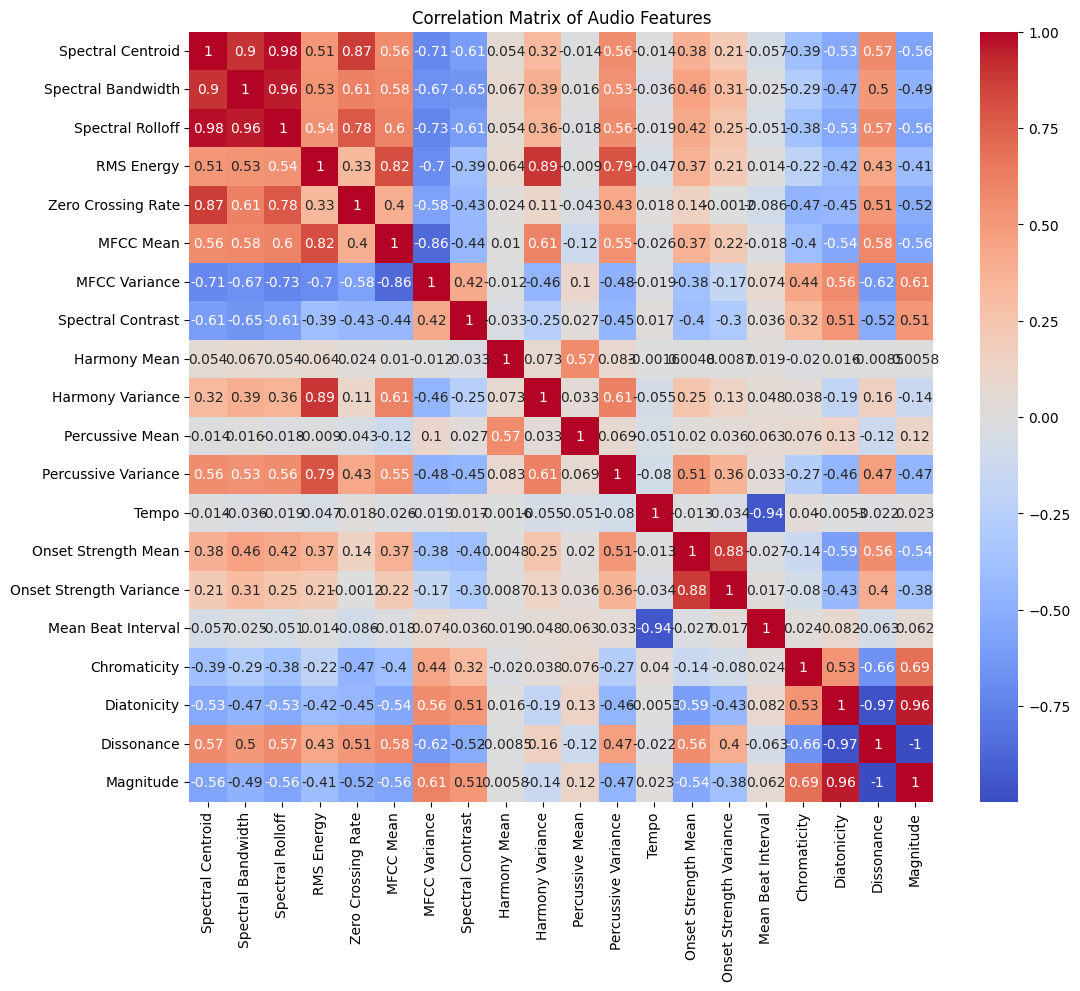

In [3]:
# @title Correlation Matrix of Audio Features

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
num_features = ['Spectral Centroid','Spectral Bandwidth','Spectral Rolloff','RMS Energy','Zero Crossing Rate','MFCC Mean','MFCC Variance','Spectral Contrast'
                ,'Harmony Mean','Harmony Variance','Percussive Mean','Percussive Variance','Tempo','Onset Strength Mean','Onset Strength Variance','Mean Beat Interval','Chromaticity'
                ,'Diatonicity','Dissonance','Magnitude']



corr_matrix = final_df[num_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
_ = plt.title('Correlation Matrix of Audio Features')

By analyzing the correlation matrix it's visible that the Spectral Centroid, Spectral Bandwidth and Spectral Rolloff are heavily related surpassing the 90% correlation mark, this also applies to Magnitude and Diatonicity. Harmony Variance and RSM Energy are just 1% under the threshold.
Zero crossing rate presents a high correlation with the spectral centroid but significantly lower to the spectral bandwidth and spectral rolloff.

Meanwhile, MFCC Variance and MFCC Mean aswell as Mean Beat Interval and Tempo, and Dissonance and Diatonicity present a big negative correlation.


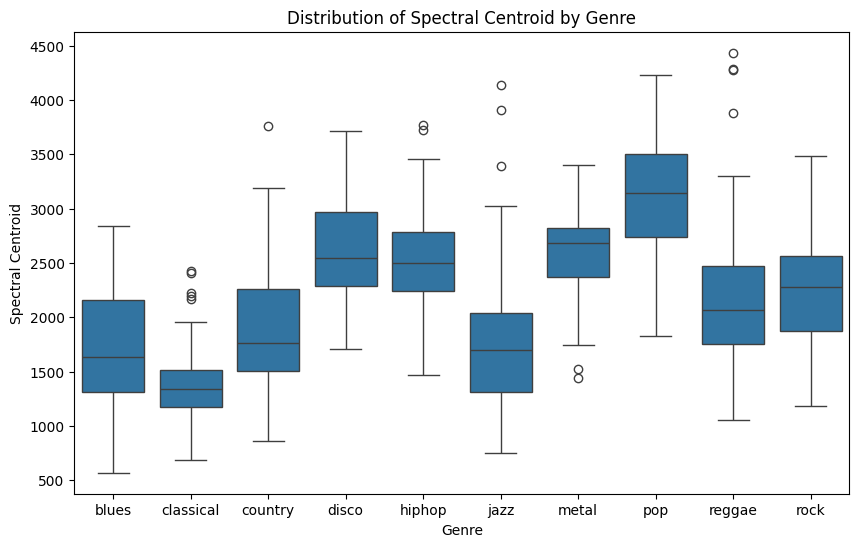

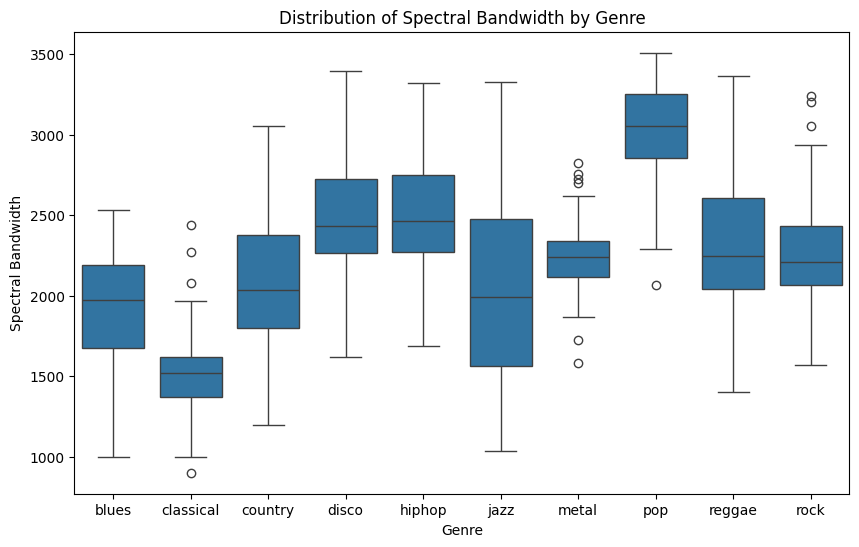

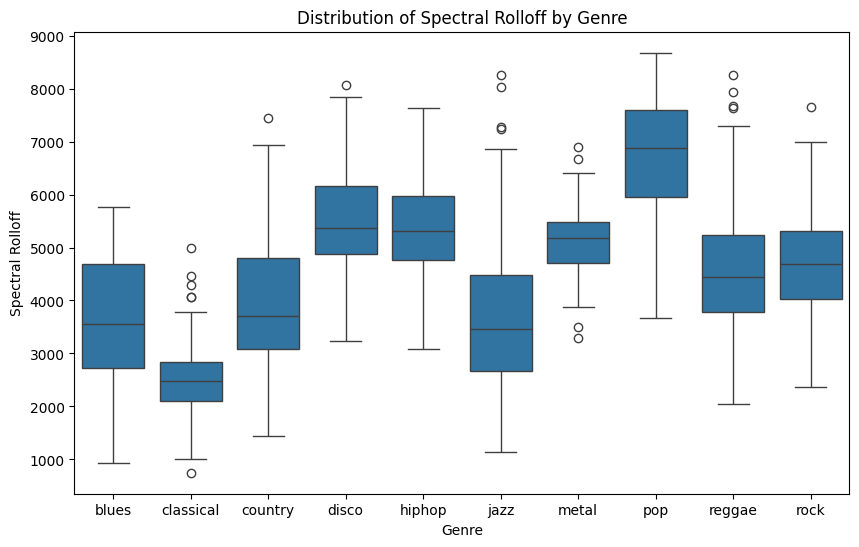

In [4]:
# @title Distribution of Spectral Centroid, Spectral Bandwidth and Spectral Rolloff by Genre

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Spectral Centroid', data=final_df)
plt.title('Distribution of Spectral Centroid by Genre')
plt.xlabel('Genre')
_ = plt.ylabel('Spectral Centroid')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Spectral Bandwidth', data=final_df)
plt.title('Distribution of Spectral Bandwidth by Genre')
plt.xlabel('Genre')
_ = plt.ylabel('Spectral Bandwidth')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Spectral Rolloff', data=final_df)
plt.title('Distribution of Spectral Rolloff by Genre')
plt.xlabel('Genre')
_ = plt.ylabel('Spectral Rolloff')


C:\Users\fabio\AppData\Local\Temp\ipykernel_20460\3223965446.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(final_df, x='MFCC Mean', y='Target', inner='stick', palette='Dark2')
C:\Users\fabio\AppData\Local\Temp\ipykernel_20460\3223965446.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(final_df, x='MFCC Variance', y='Target', inner='stick', palette='Dark2')


Text(0.5, 1.0, 'Target vs MFCC Variance')

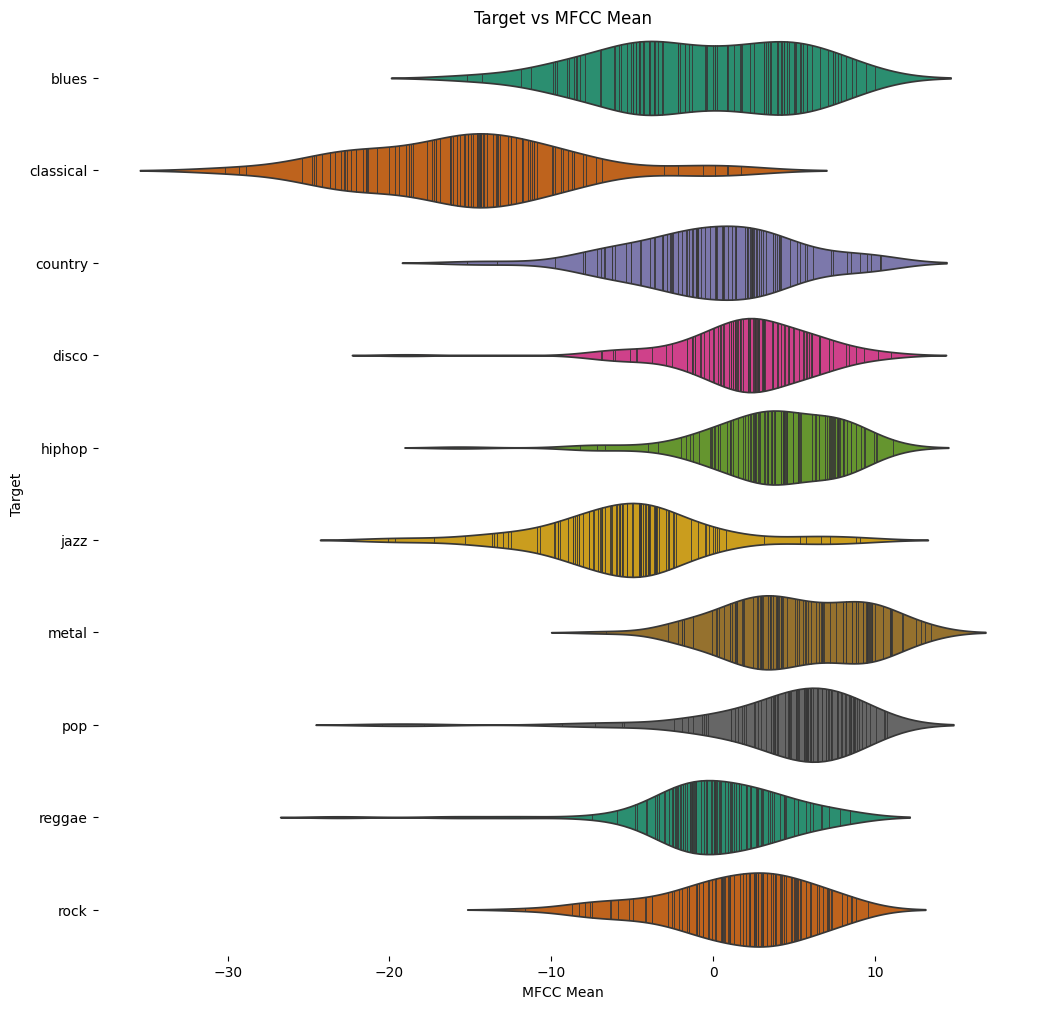

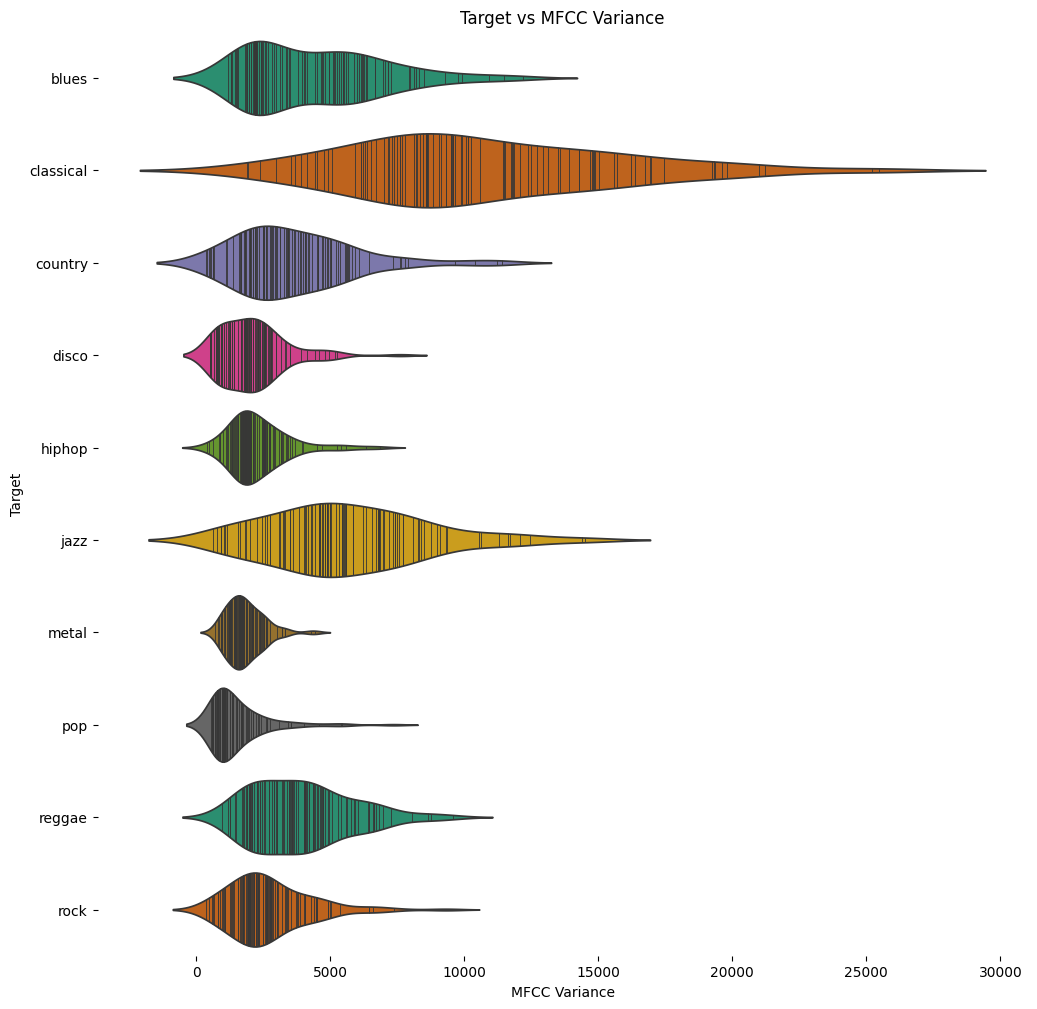

In [5]:
# @title Target vs MFCC Mean and MFCC Variance

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['Target'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='MFCC Mean', y='Target', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Target vs MFCC Mean')

figsize = (12, 1.2 * len(final_df['Target'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='MFCC Variance', y='Target', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Target vs MFCC Variance')


### Feature Importance

In [5]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

X = final_df.drop(columns=['Target'])
y = final_df['Target']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

top_features_rf = feature_importances


In [6]:
from sklearn.feature_selection import mutual_info_classif

X = final_df.drop(columns=['Target'])
y = final_df['Target']

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False).reset_index(drop=True)

top_features_mi = mi_df



In [10]:

result ={}
for feature in top_features_rf['Feature']:
    importance_rf = top_features_rf.loc[top_features_rf['Feature'] == feature, 'Importance'].values[0]
    importance_mi = top_features_mi.loc[top_features_mi['Feature'] == feature, 'Mutual Information'].values[0]
    result[feature] = (importance_rf + importance_mi) / 2

top_features = pd.DataFrame(result.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(top_features.head(10))




                   Feature  Importance
0      Onset Strength Mean    0.307579
1      Percussive Variance    0.299517
2         Spectral Rolloff    0.248244
3       Spectral Bandwidth    0.241597
4        Spectral Centroid    0.235612
5            MFCC Variance    0.234598
6  Onset Strength Variance    0.228882
7                MFCC Mean    0.226223
8               RMS Energy    0.217467
9               Dissonance    0.213995


___
## Latent Clustering

Lets reduce the dimensionality of the data to 3D, and place the data points in the latent space, colored by genre.

### UMAP

In [ ]:
!pip install umap-learn
import umap
!pip install optuna
import optuna

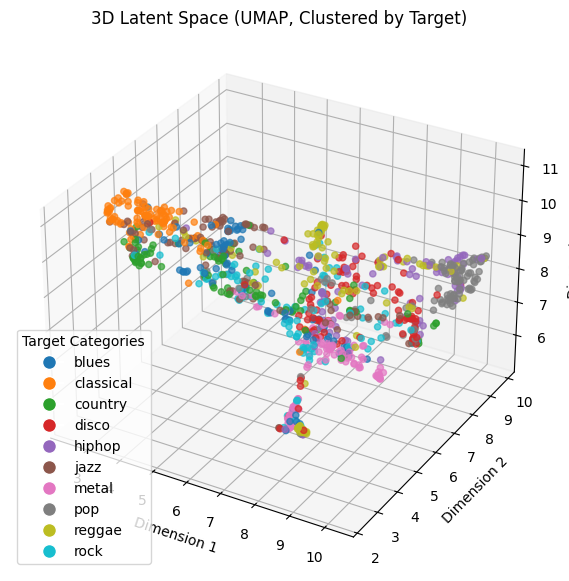

In [6]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))
colors = [color_map(category_to_color[cat]) for cat in y]

umap_reducer = umap.UMAP(n_components=3, random_state=42)
latent_space = umap_reducer.fit_transform(normalized_data)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (UMAP, Clustered by Target)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

U-MAP seems reasonable at clustering the data points, so lets further improve it. Let's check which approach yields a better result: by employing supervised information, or by pre-clustering the data.

1. Using the target label as a supervised guide, and cluster-based parameters:

Silhouette Score: 0.7732453942298889


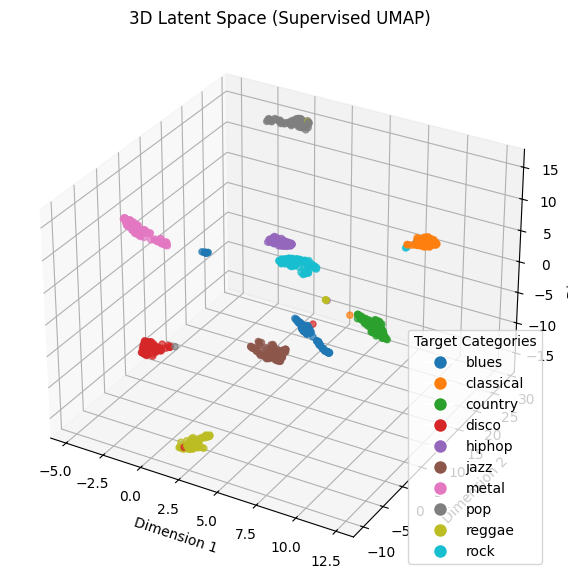

In [7]:
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

label_encoder = LabelEncoder()
encoded_targets = label_encoder.fit_transform(y)

umap_reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    metric="euclidean",
    n_neighbors=45,
    min_dist=0.3,
    target_metric="categorical",
)
latent_space = umap_reducer.fit_transform(normalized_data, y=encoded_targets)

score = silhouette_score(latent_space, encoded_targets)
print(f"Silhouette Score: {score}")

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (Supervised UMAP)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

2. Pre-clustering:

Silhouette Score: -0.0526094064116478


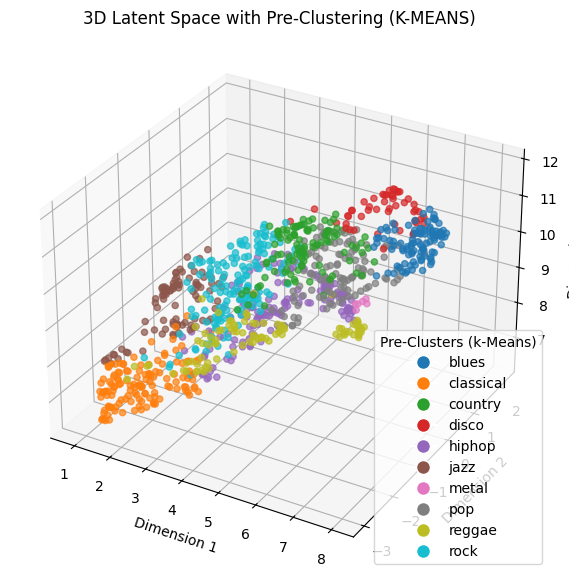

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

scaler = StandardScaler()
X = final_df.drop(columns=["Target"])
y = final_df["Target"]
normalized_data = scaler.fit_transform(X)

num_clusters = len(y.unique())
kmeans = KMeans(
        n_clusters=num_clusters,
        init="k-means++",
        random_state=42,
        n_init=10,)
cluster_labels = kmeans.fit_predict(normalized_data)

categories = y.unique()
category_to_color = {cat: i for i, cat in enumerate(categories)}
color_map = get_cmap("tab10", len(categories))
colors = [color_map(category_to_color[cat]) for cat in y]

umap_reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    n_neighbors=55,
    min_dist=0.2,
)
latent_space = umap_reducer.fit_transform(normalized_data)

score = silhouette_score(latent_space, encoded_targets)
print(f"Silhouette Score: {score}")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    latent_space[:, 2],
    c=cluster_labels,
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(num_clusters)
]
ax.legend(legend_handles, categories, title="Pre-Clusters (k-Means)")
ax.set_title("3D Latent Space with Pre-Clustering (K-MEANS)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

___
### Optimization

As it can be seen, using supervised clustering is beneficial, as each cluster seems better defined and separable in this method. It also yelds a better (non-negative silhouette). K-Means shows more overlaps, but let's find out if it can be improved.
Now, lets use optuna to tune the parameters, and see if the same outcomes are reached.

[I 2024-12-28 10:32:30,604] A new study created in memory with name: no-name-e52a3afe-2431-49ac-b5c5-3c5cb3880557
[I 2024-12-28 10:32:37,421] Trial 0 finished with value: 0.8327207565307617 and parameters: {'n_neighbors': 47, 'min_dist': 0.14615907927313648, 'metric': 'manhattan'}. Best is trial 0 with value: 0.8327207565307617.
[I 2024-12-28 10:32:43,698] Trial 1 finished with value: 0.6374385952949524 and parameters: {'n_neighbors': 24, 'min_dist': 0.14714525109804427, 'metric': 'cosine'}. Best is trial 0 with value: 0.8327207565307617.
[I 2024-12-28 10:32:46,798] Trial 2 finished with value: 0.8465662598609924 and parameters: {'n_neighbors': 43, 'min_dist': 0.05881333235981373, 'metric': 'manhattan'}. Best is trial 2 with value: 0.8465662598609924.
[I 2024-12-28 10:32:49,517] Trial 3 finished with value: 0.7176828980445862 and parameters: {'n_neighbors': 31, 'min_dist': 0.44218890077731304, 'metric': 'cosine'}. Best is trial 2 with value: 0.8465662598609924.
[I 2024-12-28 10:32:52,8

Best parameters: {'n_neighbors': 49, 'min_dist': 0.0007308135253495315, 'metric': 'manhattan'}
Best silhouette score: 0.8846634030342102


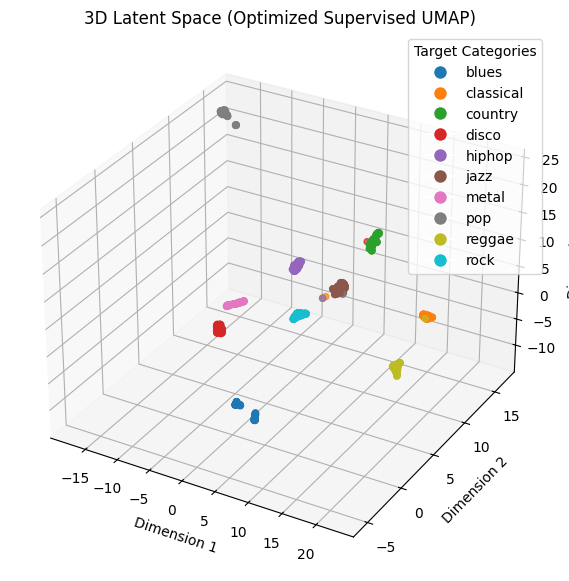

In [88]:
import optuna
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    min_dist = trial.suggest_float('min_dist', 0.0, 0.5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'cosine'])
    n_components = 3

    umap_reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        target_metric='categorical',
        random_state=42
    )

    try:
        latent_space = umap_reducer.fit_transform(normalized_data, y=encoded_targets)
        score = silhouette_score(latent_space, encoded_targets)
        return score
    except Exception as e:
        return -1.0

study = optuna.create_study(direction='maximize')
n_trials = 20
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print('Best parameters:', best_params)
print('Best silhouette score:', study.best_value)

best_umap_s = umap.UMAP(
    **best_params,
    n_components=3,
    target_metric='categorical',
    random_state=42
)

s_latent_space = best_umap_s.fit_transform(normalized_data, y=encoded_targets)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    s_latent_space[:, 0],
    s_latent_space[:, 1],
    s_latent_space[:, 2],
    c=[category_to_color[cat] for cat in y],
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(len(categories))
]
ax.legend(legend_handles, categories, title="Target Categories")

ax.set_title("3D Latent Space (Optimized Supervised UMAP)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

[I 2024-12-28 10:40:13,326] A new study created in memory with name: no-name-586e48be-b1c4-4479-a1d6-e7b99ef7ce27
[I 2024-12-28 10:40:17,716] Trial 0 finished with value: 0.4197409152984619 and parameters: {'n_neighbors': 10, 'min_dist': 0.12788540707346113}. Best is trial 0 with value: 0.4197409152984619.
[I 2024-12-28 10:40:21,785] Trial 1 finished with value: 0.4648166298866272 and parameters: {'n_neighbors': 8, 'min_dist': 0.06279685465371349}. Best is trial 1 with value: 0.4648166298866272.
[I 2024-12-28 10:40:25,218] Trial 2 finished with value: 0.45335495471954346 and parameters: {'n_neighbors': 15, 'min_dist': 0.05598394102314447}. Best is trial 1 with value: 0.4648166298866272.
[I 2024-12-28 10:40:29,478] Trial 3 finished with value: 0.40936076641082764 and parameters: {'n_neighbors': 41, 'min_dist': 0.1474480746016909}. Best is trial 1 with value: 0.4648166298866272.
[I 2024-12-28 10:40:34,077] Trial 4 finished with value: 0.3824208080768585 and parameters: {'n_neighbors': 30

Best Silhouette Score: 0.5039030313491821
Best Parameters: {'n_neighbors': 5, 'min_dist': 0.005187700226988072}


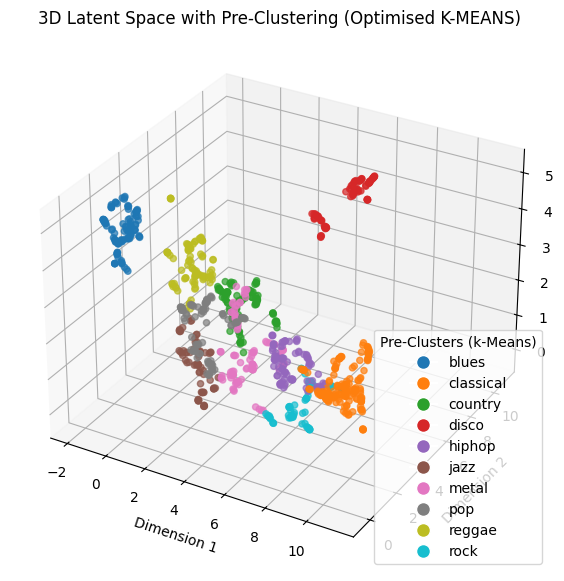

In [97]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 5, 50)
    min_dist = trial.suggest_float("min_dist", 0.0, 0.5)

    n_components = 3
    n_clusters = len(y.unique())

    try:
        umap_reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            random_state=42,
        )
        latent_space = umap_reducer.fit_transform(normalized_data)

        kmeans = KMeans(
            n_clusters=n_clusters,
            init="k-means++",
            random_state=42,
            n_init=10,
        )
        cluster_labels = kmeans.fit_predict(latent_space)

        score = silhouette_score(latent_space, cluster_labels)
        return score
    except Exception as e:
        return -1.0

study = optuna.create_study(direction="maximize")
n_trials = 20
study.optimize(objective, n_trials=n_trials)

print(f"Best Silhouette Score: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_parallel_coordinate(study)

best_umap_k = umap.UMAP(
    n_neighbors=study.best_params["n_neighbors"],
    min_dist=study.best_params["min_dist"],
    n_components=3,
    random_state=42,
)

best_kmeans = KMeans(
    n_clusters=len(y.unique()),
    init="k-means++",
    random_state=42,
    n_init=10,
)

k_latent_space = best_umap_k.fit_transform(normalized_data)
final_cluster_labels = best_kmeans.fit_predict(k_latent_space)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    k_latent_space[:, 0],
    k_latent_space[:, 1],
    k_latent_space[:, 2],
    c=final_cluster_labels,
    cmap=color_map,
    alpha=0.7,
)

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map(i), markersize=10)
    for i in range(num_clusters)
]
ax.legend(legend_handles, categories, title="Pre-Clusters (k-Means)")
ax.set_title("3D Latent Space with Pre-Clustering (Optimised K-MEANS)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

The best approach is clearly using supervised clustering, as silhouette score is much higher, and by visually inspecting, clusters are overlapping each other in pre-clustering. However, this is on in-distribution data. Let's check external examples, with novel songs.

___
## Classify new Samples

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def project_and_analyze_new_song(file_path, umap_reducer, scaler, latent_space, targets, categories, is_supervised=True, k_neighbors=150):
    y, sr = load_and_clip_audio(file_path)
    features = extract_features(y, sr)
    if features is None:
        print("Failed to extract features from the new song.")
        return

    features_df = pd.DataFrame([features])
    scaled_features = scaler.transform(features_df)

    new_song_latent = umap_reducer.transform(scaled_features)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    if is_supervised:
        unique_targets = np.unique(targets)
        color_map = plt.cm.get_cmap('tab10', len(unique_targets))
        colors = [color_map(np.where(unique_targets == t)[0][0]) for t in targets]
    else:
        color_map = plt.cm.get_cmap('tab10', len(categories))
        colors = [color_map(t) for t in targets]  # targets are already cluster labels in k-means

    scatter = ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=colors, alpha=0.7)

    new_song_latent[0, 1] -= 0.5 # adjust position to make it more visible
    new_song_latent[0, 2] += 0.5 # adjust position to make it more visible
    new_song_plot = ax.scatter(new_song_latent[0, 0], new_song_latent[0, 1], new_song_latent[0, 2],
                               c='white', edgecolors='black', s=200, marker='*', zorder=10)


    legend_elements = [plt.Line2D([0], [0], marker="o", color='w', markerfacecolor=color_map(i),
                                  markersize=10, label=cat) for i, cat in enumerate(categories)]
    legend_elements.append(plt.Line2D([0], [0], marker="*", color='w', markerfacecolor='white',
                                      markeredgecolor='black', markersize=15, label='New Song'))

    ax.legend(handles=legend_elements, title="Categories", loc='best')

    ax.set_title(f"3D Latent Space {'(Supervised UMAP)' if is_supervised else '(UMAP with K-means)'}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.tight_layout()
    plt.show()

    distances = np.linalg.norm(latent_space - new_song_latent, axis=1)

    closest_indices = np.argsort(distances)[:k_neighbors]

    nearest_genres = [categories[targets[i]] for i in closest_indices]
    assigned_genre = pd.Series(nearest_genres).value_counts().index[0]

    report = f"\nNew Song Analysis:\n"
    report += f"Assigned Genre: {assigned_genre}\n"
    report += f"Genre Distribution (Top {k_neighbors} nearest):\n"
    for genre, count in pd.Series(nearest_genres).value_counts().items():
        report += f"  {genre}: {count}\n"
    report += f"\nFeatures:\n"
    for feature, value in features.items():
        if isinstance(value, np.ndarray):
            report += f"  {feature}: {value.mean():.4f} (mean)\n"
        else:
            report += f"  {feature}: {value:.4f}\n"

    print(report)
    return new_song_latent, features, assigned_genre, report


___
### Testing Inference:

Let's try to test both methods, with new songs, not used in defining the latent space. The distribution of these new samples is different, so their latent representation may be different.

___
metal

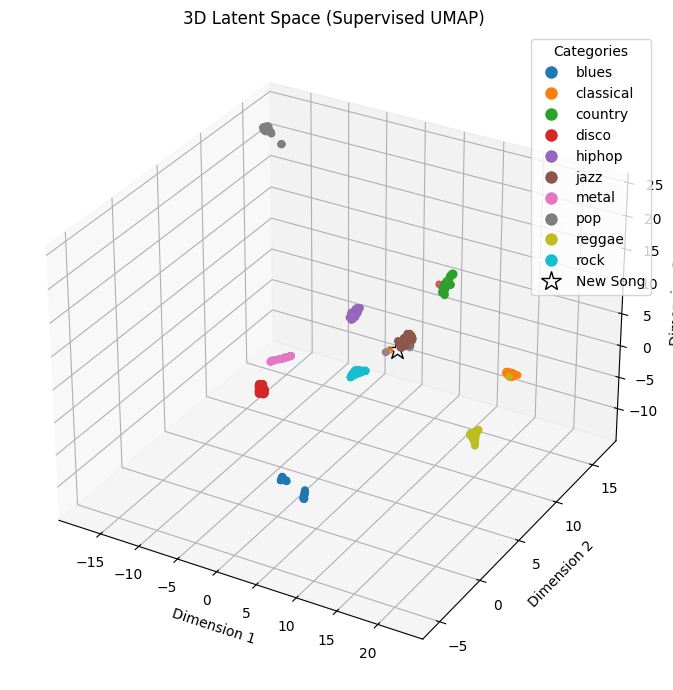


New Song Analysis:
Assigned Genre: jazz
Genre Distribution (Top 150 nearest):
  jazz: 99
  rock: 44
  reggae: 3
  pop: 2
  classical: 1
  hiphop: 1

Features:
  Spectral Centroid: 2664.8539
  Spectral Bandwidth: 2838.4977
  Spectral Rolloff: 5578.6582
  RMS Energy: 0.1002
  Zero Crossing Rate: 0.0517
  MFCC Mean: 0.4829
  MFCC Variance: 5338.3818
  Spectral Contrast: 19.5899
  Harmony Mean: -0.0001
  Harmony Variance: 0.0090
  Percussive Mean: -0.0004
  Percussive Variance: 0.0011
  Tempo: 89.2857 (mean)
  Onset Strength Mean: 1.0253
  Onset Strength Variance: 1.0230
  Mean Beat Interval: 0.6642
  Chromaticity: 0.1147
  Diatonicity: 0.1155
  Dissonance: 0.8870
  Magnitude: 1.0224



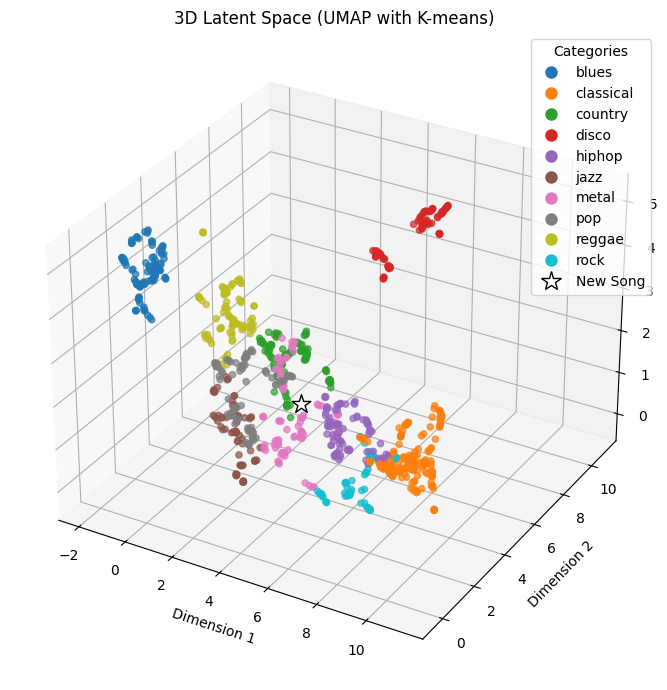


New Song Analysis:
Assigned Genre: metal
Genre Distribution (Top 150 nearest):
  metal: 98
  country: 47
  jazz: 4
  pop: 1

Features:
  Spectral Centroid: 2664.8539
  Spectral Bandwidth: 2838.4977
  Spectral Rolloff: 5578.6582
  RMS Energy: 0.1002
  Zero Crossing Rate: 0.0517
  MFCC Mean: 0.4829
  MFCC Variance: 5338.3818
  Spectral Contrast: 19.5899
  Harmony Mean: -0.0001
  Harmony Variance: 0.0090
  Percussive Mean: -0.0004
  Percussive Variance: 0.0011
  Tempo: 89.2857 (mean)
  Onset Strength Mean: 1.0253
  Onset Strength Variance: 1.0230
  Mean Beat Interval: 0.6642
  Chromaticity: 0.1147
  Diatonicity: 0.1155
  Dissonance: 0.8870
  Magnitude: 1.0224



In [103]:
new_song_file = "metal.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

___
country

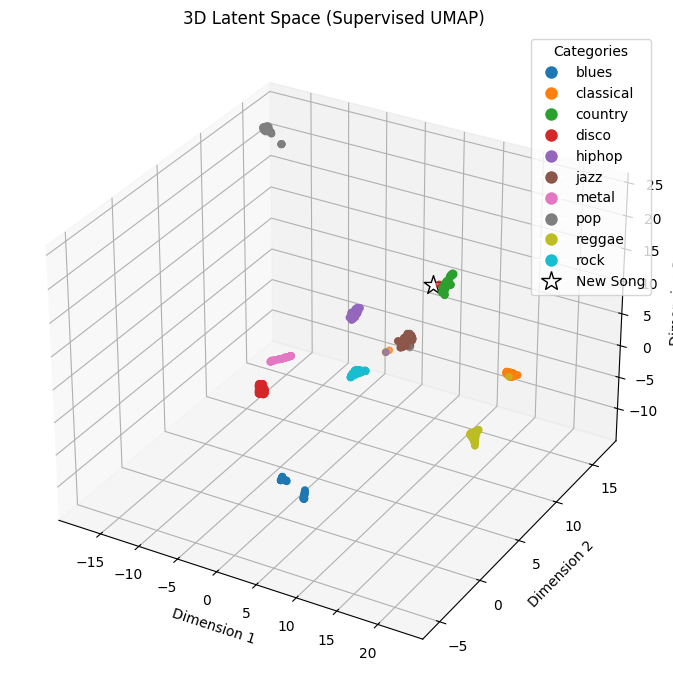


New Song Analysis:
Assigned Genre: country
Genre Distribution (Top 150 nearest):
  country: 100
  jazz: 49
  disco: 1

Features:
  Spectral Centroid: 2114.6448
  Spectral Bandwidth: 2715.1203
  Spectral Rolloff: 4454.4481
  RMS Energy: 0.2732
  Zero Crossing Rate: 0.0382
  MFCC Mean: 3.6186
  MFCC Variance: 3473.1331
  Spectral Contrast: 23.0243
  Harmony Mean: 0.0003
  Harmony Variance: 0.0637
  Percussive Mean: 0.0023
  Percussive Variance: 0.0049
  Tempo: 143.5547 (mean)
  Onset Strength Mean: 1.2198
  Onset Strength Variance: 2.4829
  Mean Beat Interval: 0.4239
  Chromaticity: 0.3070
  Diatonicity: 0.2434
  Dissonance: 0.7705
  Magnitude: 2.2033



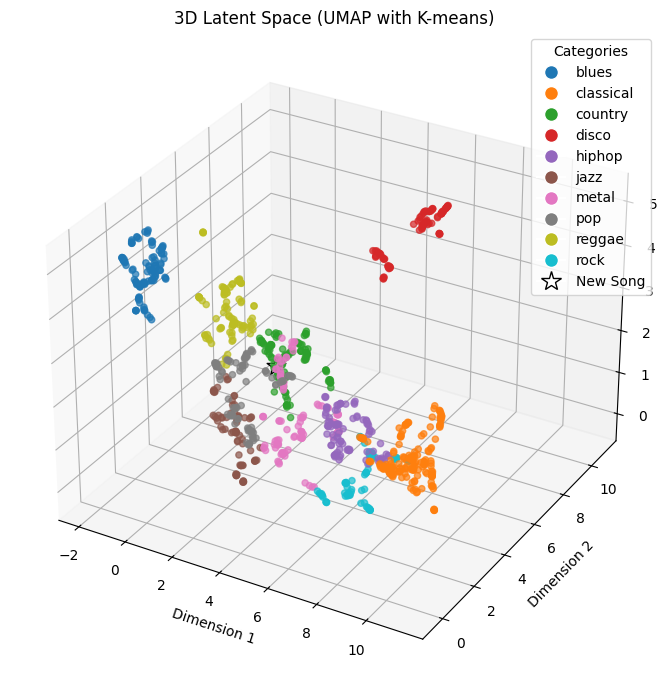


New Song Analysis:
Assigned Genre: pop
Genre Distribution (Top 150 nearest):
  pop: 91
  hiphop: 36
  metal: 22
  country: 1

Features:
  Spectral Centroid: 2114.6448
  Spectral Bandwidth: 2715.1203
  Spectral Rolloff: 4454.4481
  RMS Energy: 0.2732
  Zero Crossing Rate: 0.0382
  MFCC Mean: 3.6186
  MFCC Variance: 3473.1331
  Spectral Contrast: 23.0243
  Harmony Mean: 0.0003
  Harmony Variance: 0.0637
  Percussive Mean: 0.0023
  Percussive Variance: 0.0049
  Tempo: 143.5547 (mean)
  Onset Strength Mean: 1.2198
  Onset Strength Variance: 2.4829
  Mean Beat Interval: 0.4239
  Chromaticity: 0.3070
  Diatonicity: 0.2434
  Dissonance: 0.7705
  Magnitude: 2.2033



In [138]:
new_song_file = "country.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

___
classical

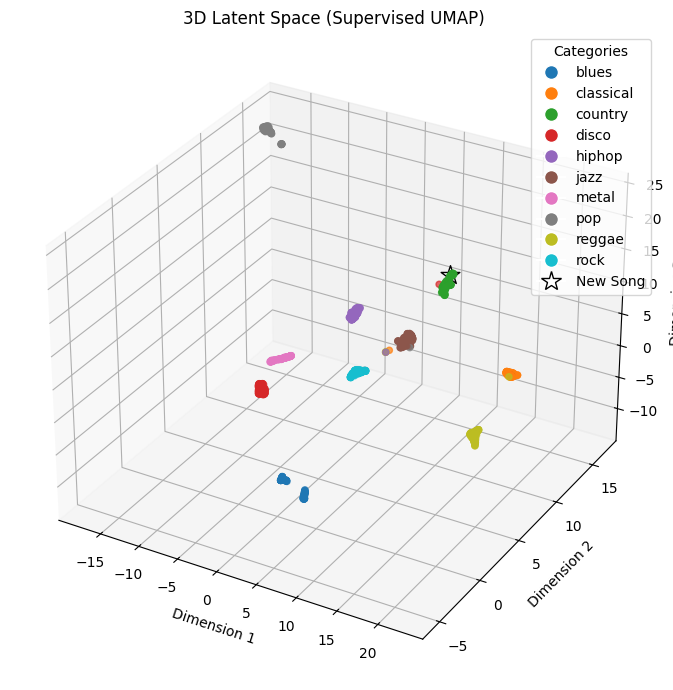


New Song Analysis:
Assigned Genre: country
Genre Distribution (Top 150 nearest):
  country: 100
  jazz: 49
  disco: 1

Features:
  Spectral Centroid: 1309.4629
  Spectral Bandwidth: 1884.2291
  Spectral Rolloff: 2469.2851
  RMS Energy: 0.1842
  Zero Crossing Rate: 0.0265
  MFCC Mean: -0.6112
  MFCC Variance: 6816.1523
  Spectral Contrast: 23.9160
  Harmony Mean: -0.0000
  Harmony Variance: 0.0327
  Percussive Mean: -0.0001
  Percussive Variance: 0.0009
  Tempo: 69.8374 (mean)
  Onset Strength Mean: 0.9663
  Onset Strength Variance: 0.9352
  Mean Beat Interval: 0.8573
  Chromaticity: 0.4020
  Diatonicity: 0.3365
  Dissonance: 0.6452
  Magnitude: 3.4204



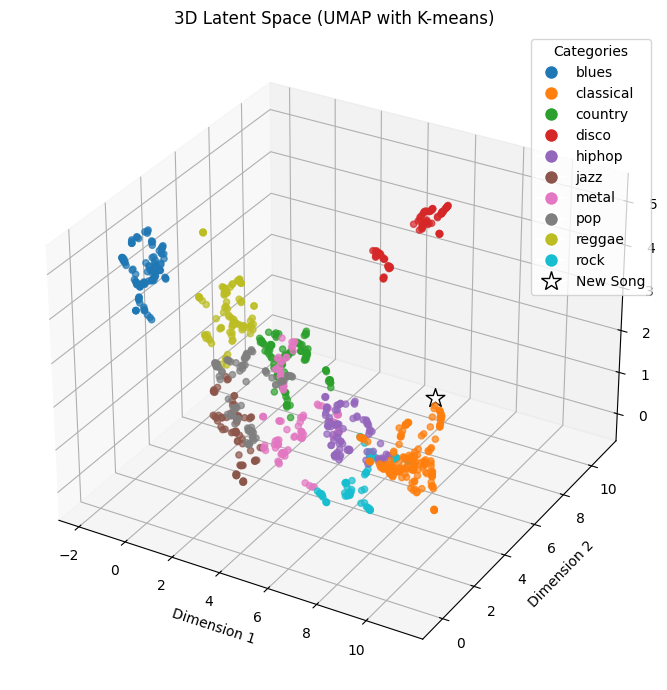


New Song Analysis:
Assigned Genre: classical
Genre Distribution (Top 150 nearest):
  classical: 150

Features:
  Spectral Centroid: 1309.4629
  Spectral Bandwidth: 1884.2291
  Spectral Rolloff: 2469.2851
  RMS Energy: 0.1842
  Zero Crossing Rate: 0.0265
  MFCC Mean: -0.6112
  MFCC Variance: 6816.1523
  Spectral Contrast: 23.9160
  Harmony Mean: -0.0000
  Harmony Variance: 0.0327
  Percussive Mean: -0.0001
  Percussive Variance: 0.0009
  Tempo: 69.8374 (mean)
  Onset Strength Mean: 0.9663
  Onset Strength Variance: 0.9352
  Mean Beat Interval: 0.8573
  Chromaticity: 0.4020
  Diatonicity: 0.3365
  Dissonance: 0.6452
  Magnitude: 3.4204



In [105]:
new_song_file = "classical.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

___
hiphop

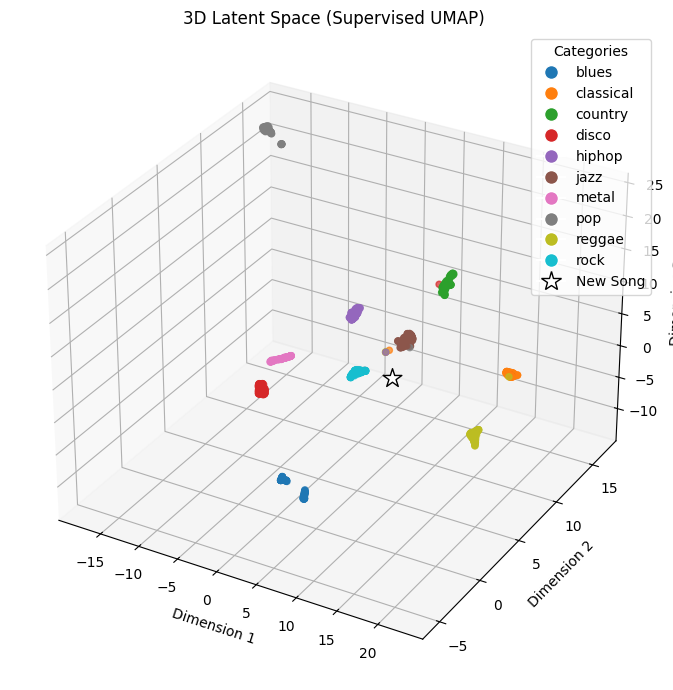


New Song Analysis:
Assigned Genre: jazz
Genre Distribution (Top 150 nearest):
  jazz: 99
  rock: 44
  reggae: 3
  pop: 2
  hiphop: 1
  classical: 1

Features:
  Spectral Centroid: 1662.7980
  Spectral Bandwidth: 2039.0063
  Spectral Rolloff: 3343.9631
  RMS Energy: 0.0881
  Zero Crossing Rate: 0.0316
  MFCC Mean: -7.1854
  MFCC Variance: 11842.8486
  Spectral Contrast: 22.5436
  Harmony Mean: 0.0001
  Harmony Variance: 0.0076
  Percussive Mean: 0.0001
  Percussive Variance: 0.0016
  Tempo: 178.2058 (mean)
  Onset Strength Mean: 1.3700
  Onset Strength Variance: 6.8700
  Mean Beat Interval: 0.3332
  Chromaticity: 0.2077
  Diatonicity: 0.1146
  Dissonance: 0.8749
  Magnitude: 1.1979



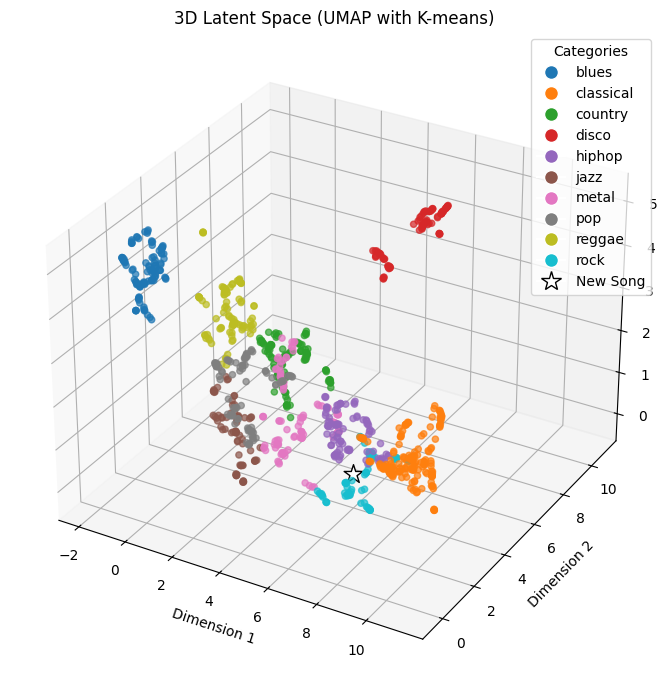


New Song Analysis:
Assigned Genre: hiphop
Genre Distribution (Top 150 nearest):
  hiphop: 88
  rock: 37
  classical: 25

Features:
  Spectral Centroid: 1662.7980
  Spectral Bandwidth: 2039.0063
  Spectral Rolloff: 3343.9631
  RMS Energy: 0.0881
  Zero Crossing Rate: 0.0316
  MFCC Mean: -7.1854
  MFCC Variance: 11842.8486
  Spectral Contrast: 22.5436
  Harmony Mean: 0.0001
  Harmony Variance: 0.0076
  Percussive Mean: 0.0001
  Percussive Variance: 0.0016
  Tempo: 178.2058 (mean)
  Onset Strength Mean: 1.3700
  Onset Strength Variance: 6.8700
  Mean Beat Interval: 0.3332
  Chromaticity: 0.2077
  Diatonicity: 0.1146
  Dissonance: 0.8749
  Magnitude: 1.1979



In [110]:
new_song_file = "hiphop.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

___
disco

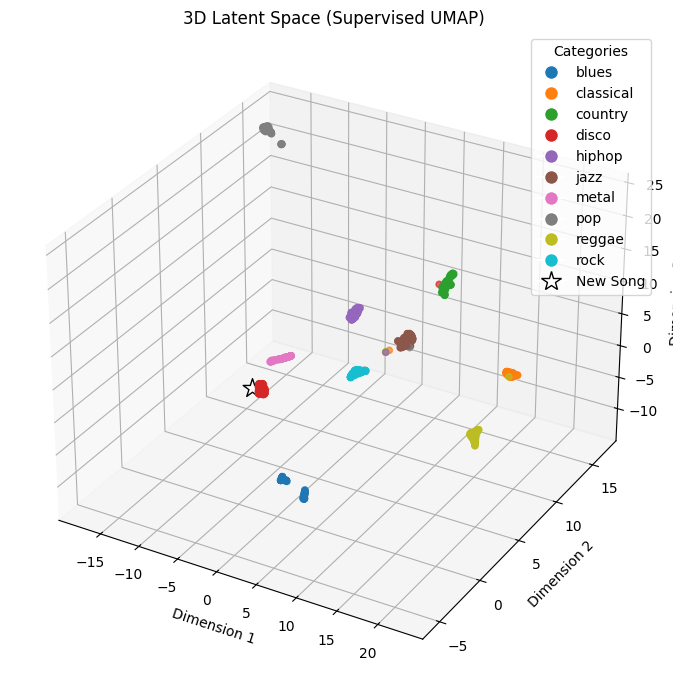


New Song Analysis:
Assigned Genre: disco
Genre Distribution (Top 150 nearest):
  disco: 98
  hiphop: 52

Features:
  Spectral Centroid: 4728.1663
  Spectral Bandwidth: 4827.0462
  Spectral Rolloff: 10387.9366
  RMS Energy: 0.1305
  Zero Crossing Rate: 0.1011
  MFCC Mean: -0.9587
  MFCC Variance: 3488.0476
  Spectral Contrast: 20.6222
  Harmony Mean: 0.0001
  Harmony Variance: 0.0130
  Percussive Mean: -0.0001
  Percussive Variance: 0.0080
  Tempo: 127.8409 (mean)
  Onset Strength Mean: 1.3214
  Onset Strength Variance: 3.6485
  Mean Beat Interval: 0.4652
  Chromaticity: 0.1126
  Diatonicity: 0.0620
  Dissonance: 0.9467
  Magnitude: 0.5072



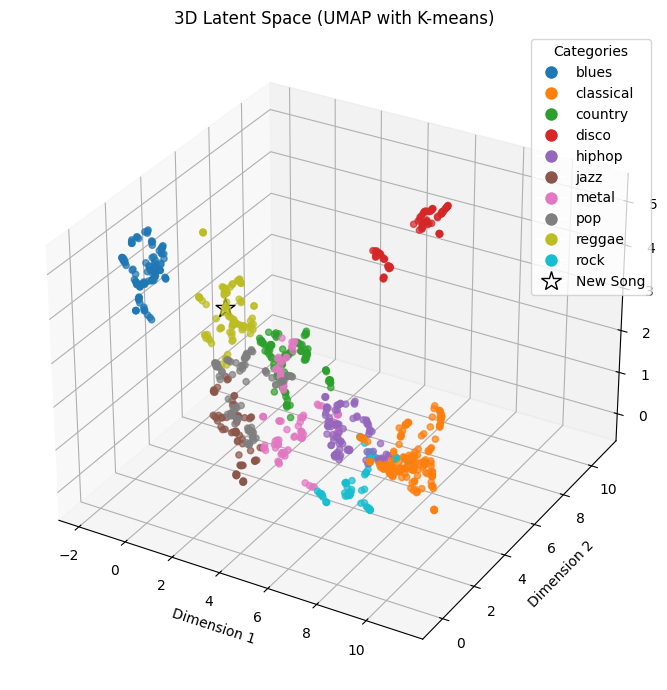


New Song Analysis:
Assigned Genre: reggae
Genre Distribution (Top 150 nearest):
  reggae: 93
  country: 31
  jazz: 21
  blues: 5

Features:
  Spectral Centroid: 4728.1663
  Spectral Bandwidth: 4827.0462
  Spectral Rolloff: 10387.9366
  RMS Energy: 0.1305
  Zero Crossing Rate: 0.1011
  MFCC Mean: -0.9587
  MFCC Variance: 3488.0476
  Spectral Contrast: 20.6222
  Harmony Mean: 0.0001
  Harmony Variance: 0.0130
  Percussive Mean: -0.0001
  Percussive Variance: 0.0080
  Tempo: 127.8409 (mean)
  Onset Strength Mean: 1.3214
  Onset Strength Variance: 3.6485
  Mean Beat Interval: 0.4652
  Chromaticity: 0.1126
  Diatonicity: 0.0620
  Dissonance: 0.9467
  Magnitude: 0.5072



In [137]:
new_song_file = "disco.mp3"

# supervised
result_s = project_and_analyze_new_song(
    new_song_file, best_umap_s, scaler, s_latent_space,
    encoded_targets, categories, is_supervised=True
)

# pre-clustered
result_k = project_and_analyze_new_song(
    new_song_file, best_umap_k, scaler, k_latent_space,
    final_cluster_labels, categories, is_supervised=False
)

---
As we can see, there is not a one-size-fits all solution. Surprisingly, the pre-clustering approach, although led to a latent space with lower silhouette, it performed remarkably well:

| Real Genre | Supervised UMAP | Pre-clustered UMAP |
|------------|-----------------|---------------------|
| **Metal**  | Jazz            | **Metal**           |
| **Country**| **Country**     | Pop                 |
|**Classical**| Country        | **Classical**       |
| **Hip-hop**| Jazz            | **Hip-hop**         |
| **Disco**  | **Disco**       | Reggae              |

___

The pre-clustered UMAP approach seems to perform slightly better, correctly classifying 3 out of 5 genres, while the supervised UMAP correctly classifies 2 out of 5.

**Interpretation**

- **Metal**: Correctly identified by pre-clustered UMAP, but misclassified as Jazz by supervised UMAP. This could be due to some shared characteristics between metal and jazz, such as complex rhythms.

- **Country**: Correctly identified by supervised UMAP, but misclassified as Pop by pre-clustered UMAP. This might be due to the blurry lines between these genres, and since this apporach overlaps boudaries, it may be skewed to the side of Pop.

- **Classical**: Correctly identified by pre-clustered UMAP, but misclassified as Country by supervised UMAP. This weird phenomenon might be due to certain features (e.g., string instruments) being overemphasized in the supervised model.

- **Hip-hop**: Correctly identified by pre-clustered UMAP, but misclassified as Jazz by supervised UMAP. This could be due to shared characteristics like syncopated rhythms and the use of samples.

- **Disco**: Correctly identified by supervised UMAP, but misclassified as Reggae by pre-clustered UMAP. This might be due to similarities in rhythm and bass-heavy production between these genres.


**Insights**:

- The supervised UMAP seems to have a bias towards Jazz. This could indicate that the supervised model is overfitting to certain features common in Jazz music.

- The pre-clustered UMAP appears to be more accurate overall, but still struggles with some genres. Its misclassifications (Country as Pop, Disco as Reggae) are between genres that often share some musical characteristics.
